In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import measure, filters, morphology

# # 1. Görüntü normalize et
# def normalize(img):
#     return (img - np.min(img)) / (np.max(img) - np.min(img))

# # 2. Kontrast artırma - gamma artırma
# def adjust_gamma(img, gamma=1.5):
#     look_up_table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
#     return cv2.LUT(img, look_up_table)

# # 3. Görüntü üzerinde işlemler
# img_norm = normalize(img_aggregate)  # Görüntü normalizasyonu
# img_gamma = adjust_gamma((img_norm * 255).astype(np.uint8), gamma=2.0)  # Kontrast artırma (gamma düzeltmesi)

# # 4. Eşikleme işlemi
# threshold_value = filters.threshold_otsu(img_gamma)  # Otsu yöntemi ile eşik değeri
# binary_img = img_gamma > threshold_value

# # 5. Küçük gürültüleri temizle
# clean_img = morphology.remove_small_objects(binary_img, min_size=10)

# # 6. Bağlantılı bileşen analizi ve agregat sayma
# labeled_img = measure.label(clean_img)
# num_aggregates = labeled_img.max()

# # 7. Görselleştirme
# plt.figure(figsize=(12, 5))

# # Orijinal ve işlenmiş görüntüleri yan yana göster
# plt.subplot(1, 2, 1)
# plt.imshow(img_gamma, cmap='gray')
# plt.title('Gamma Artırılmış Görüntü')
# plt.axis('off')

# # Bağlantılı bileşenlerin gösterimi (Renkli agregatlar)
# plt.subplot(1, 2, 2)
# plt.imshow(labeled_img, cmap='nipy_spectral')
# plt.title(f'Aggregates Detected: {num_aggregates}')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# print(f"Toplam agregat sayısı: {num_aggregates}")


In [2]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted
from skimage import measure, morphology





Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [3]:
file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"
img = io.imread(file_name) # (9, 4, 1024, 1024)
print(f'img       : {img.shape}')

# NUCLEI
img_nuclei = img[:, 0, :, :]
# img_nuclei = img_nuclei[6, :, :]
print(f'Nuclei    : {img_nuclei.shape}')

# NUCLEI
img_aggregate = img[:, 2, :, :]
# img_aggregate = img_aggregate[6, :, :]
print(f'Aggregate : {img_aggregate.shape}')

# CELL BODY
img_cellbody = img[:, 3, :, :]
# img_cellbody = img_cellbody[6, :, :]
print(f'Cell body : {img_cellbody.shape}')


100%|██████████| 36/36 [00:00<00:00, 589.28it/s]

img       : (9, 4, 1024, 1024)
Nuclei    : (9, 1024, 1024)
Aggregate : (9, 1024, 1024)
Cell body : (9, 1024, 1024)


In [4]:
# Process aggregates (Channel 2)
def process_aggregates(img):
    aggregate_masks = []
    for z_slice in range(img.shape[0]):
        slice_img = img[z_slice, 2, :, :]  # Channel 2 for aggregates
        threshold = 0.6 * np.max(slice_img)
        bright_spots = slice_img > threshold
        clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)
        aggregate_masks.append(clean_mask)
    return aggregate_masks

aggregate_masks = process_aggregates(img)


In [5]:
aggregate_stack = np.stack(aggregate_masks, axis=0)  # shape: (Z, Y, X)


from scipy.ndimage import label
labeled_aggregates, num_aggregates = label(aggregate_stack)


from skimage.measure import regionprops

props = regionprops(labeled_aggregates)

for i, region in enumerate(props):
    print(f"Agregat {i+1}:")
    print("  - Voxel sayısı (hacim):", region.area)
    print("  - Ağırlık merkezi:", region.centroid)

total_aggregates = len(props)
total_volume = sum([r.area for r in props])
average_volume = total_volume / total_aggregates if total_aggregates > 0 else 0


Agregat 1:
  - Voxel sayısı (hacim): 72.0
  - Ağırlık merkezi: (1.6111111111111112, 527.3611111111111, 474.7083333333333)
Agregat 2:
  - Voxel sayısı (hacim): 94.0
  - Ağırlık merkezi: (1.8085106382978724, 606.8510638297872, 495.8829787234043)
Agregat 3:
  - Voxel sayısı (hacim): 64.0
  - Ağırlık merkezi: (1.71875, 661.890625, 400.375)
Agregat 4:
  - Voxel sayısı (hacim): 172.0
  - Ağırlık merkezi: (2.366279069767442, 672.0697674418604, 399.0755813953488)
Agregat 5:
  - Voxel sayısı (hacim): 45.0
  - Ağırlık merkezi: (2.1333333333333333, 600.6666666666666, 491.55555555555554)
Agregat 6:
  - Voxel sayısı (hacim): 54.0
  - Ağırlık merkezi: (2.111111111111111, 628.4814814814815, 396.14814814814815)
Agregat 7:
  - Voxel sayısı (hacim): 669.0
  - Ağırlık merkezi: (2.8535127055306426, 643.4319880418535, 404.4708520179372)
Agregat 8:
  - Voxel sayısı (hacim): 358.0
  - Ağırlık merkezi: (3.494413407821229, 336.27932960893855, 710.0167597765363)
Agregat 9:
  - Voxel sayısı (hacim): 114.0
  - Ağ

In [6]:
import pandas as pd

df = pd.DataFrame([{
    'id': i+1,
    'volume': r.area,
    'centroid_z': r.centroid[0],
    'centroid_y': r.centroid[1],
    'centroid_x': r.centroid[2]
} for i, r in enumerate(props)])

df.to_csv("aggregates_summary.csv", index=False)


In [7]:
import matplotlib.pyplot as plt
from skimage.measure import label
import napari
import numpy as np

from scipy.ndimage import label

import napari
import numpy as np
from scipy.ndimage import label

# Z, C, Y, X boyutundaki img üzerinden çalışıyoruz

# Kanal 0: Nucleus (çekirdek), Kanal 1/3: Hücre, Kanal 2: Agregat
nucleus = img[:, 0, :, :]
cell_body = img[:, 3, :, :]  # ya da 1


aggregate_stack = np.stack(aggregate_masks, axis=0)
labeled_aggregates, num_aggregates = label(aggregate_stack)

# Napari ile 3D görselleştirme
viewer = napari.Viewer(ndisplay=3)  # 3D gösterim için
viewer.add_image(nucleus, name="Nucleus", colormap="gray", blending="additive", scale=(1, 1, 1))
viewer.add_image(cell_body, name="Cell Body", colormap="green", blending="additive", scale=(1, 1, 1))
viewer.add_labels(labeled_aggregates, name="Aggregates", opacity=0.6, scale=(1, 1, 1))

napari.run()

# # Napari ile görselleştir
# viewer = napari.Viewer()
# viewer.add_image(nucleus, name="Nucleus", colormap="gray", blending="additive")
# viewer.add_image(cell_body, name="Cell Body", colormap="green", blending="additive")
# viewer.add_labels(labeled_aggregates, name="Aggregates", opacity=0.6)
# napari.run()



# # 3D mask oluştur
# aggregate_stack = np.stack(aggregate_masks, axis=0)
# # labeled_aggregates, _ = label(aggregate_stack)
# labeled_aggregates, num_aggregates = label(aggregate_stack)


# # Napari ile 3D renklendirme
# viewer = napari.Viewer()
# viewer.add_labels(labeled_aggregates, name="Aggregates")
# napari.run()


08-May-25 11:46:05 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


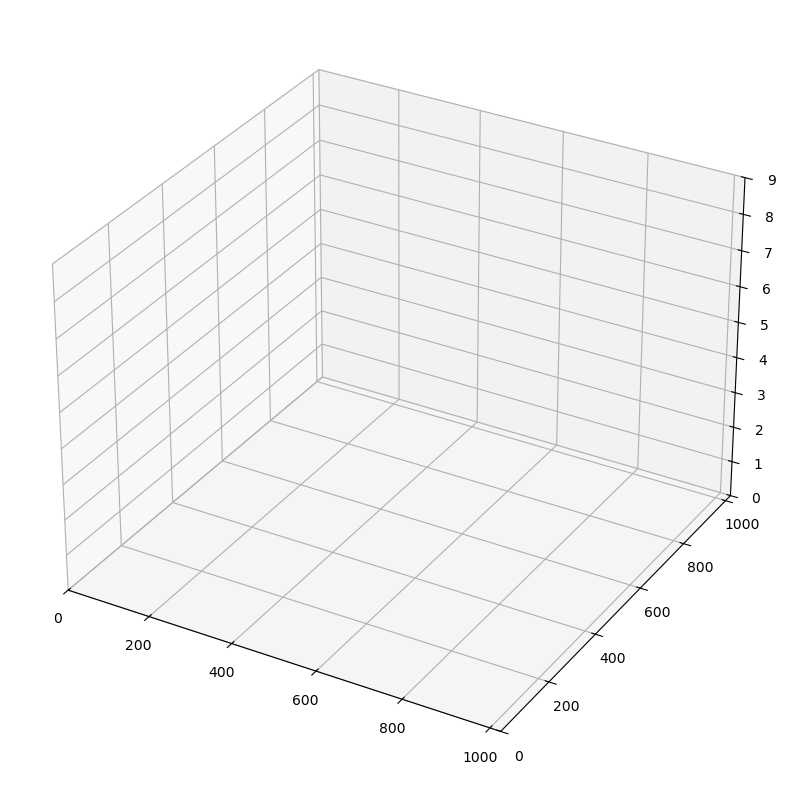

: 

In [8]:
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

verts, faces, _, _ = marching_cubes(labeled_aggregates > 0, level=0)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces], alpha=0.7)
mesh.set_facecolor([0.5, 0.5, 1])
ax.add_collection3d(mesh)

ax.set_xlim(0, labeled_aggregates.shape[2])
ax.set_ylim(0, labeled_aggregates.shape[1])
ax.set_zlim(0, labeled_aggregates.shape[0])
plt.tight_layout()
plt.show()
